In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, f_classif



In [2]:
# Load the dataset
df = pd.read_csv('/content/ad_click_dataset.csv')
# Initial exploration
print(f"Dataset shape: {df.shape}")
print("\nData types:")
print(df.dtypes)
print("\nMissing values:")
print(df.isnull().sum())
print("\nSummary statistics:")
print(df.describe())

Dataset shape: (10000, 9)

Data types:
id                    int64
full_name            object
age                 float64
gender               object
device_type          object
ad_position          object
browsing_history     object
time_of_day          object
click                 int64
dtype: object

Missing values:
id                     0
full_name              0
age                 4766
gender              4693
device_type         2000
ad_position         2000
browsing_history    4782
time_of_day         2000
click                  0
dtype: int64

Summary statistics:
                 id          age         click
count  10000.000000  5234.000000  10000.000000
mean    5060.211400    40.197363      0.650000
std     2861.758265    13.126420      0.476993
min        5.000000    18.000000      0.000000
25%     2529.000000    29.000000      0.000000
50%     5218.000000    39.500000      1.000000
75%     7466.000000    52.000000      1.000000
max    10000.000000    64.000000      1.000

In [3]:
# Drop 'id' and 'full_name' as they don't contribute to prediction
df = df.drop(['id', 'full_name'], axis=1)

# Handle missing values
# For numerical (age), impute with median
df['age'] = df['age'].fillna(df['age'].median())

# For categorical, impute with mode or 'Unknown'
categorical_cols = ['gender', 'device_type', 'ad_position', 'browsing_history', 'time_of_day']
for col in categorical_cols:
    df[col] = df[col].fillna('Unknown')

# Verify no more missing values
print("\nMissing values after imputation:")
print(df.isnull().sum())

# Check class balance
print("\nClass distribution:")
print(df['click'].value_counts(normalize=True))


Missing values after imputation:
age                 0
gender              0
device_type         0
ad_position         0
browsing_history    0
time_of_day         0
click               0
dtype: int64

Class distribution:
click
1    0.65
0    0.35
Name: proportion, dtype: float64


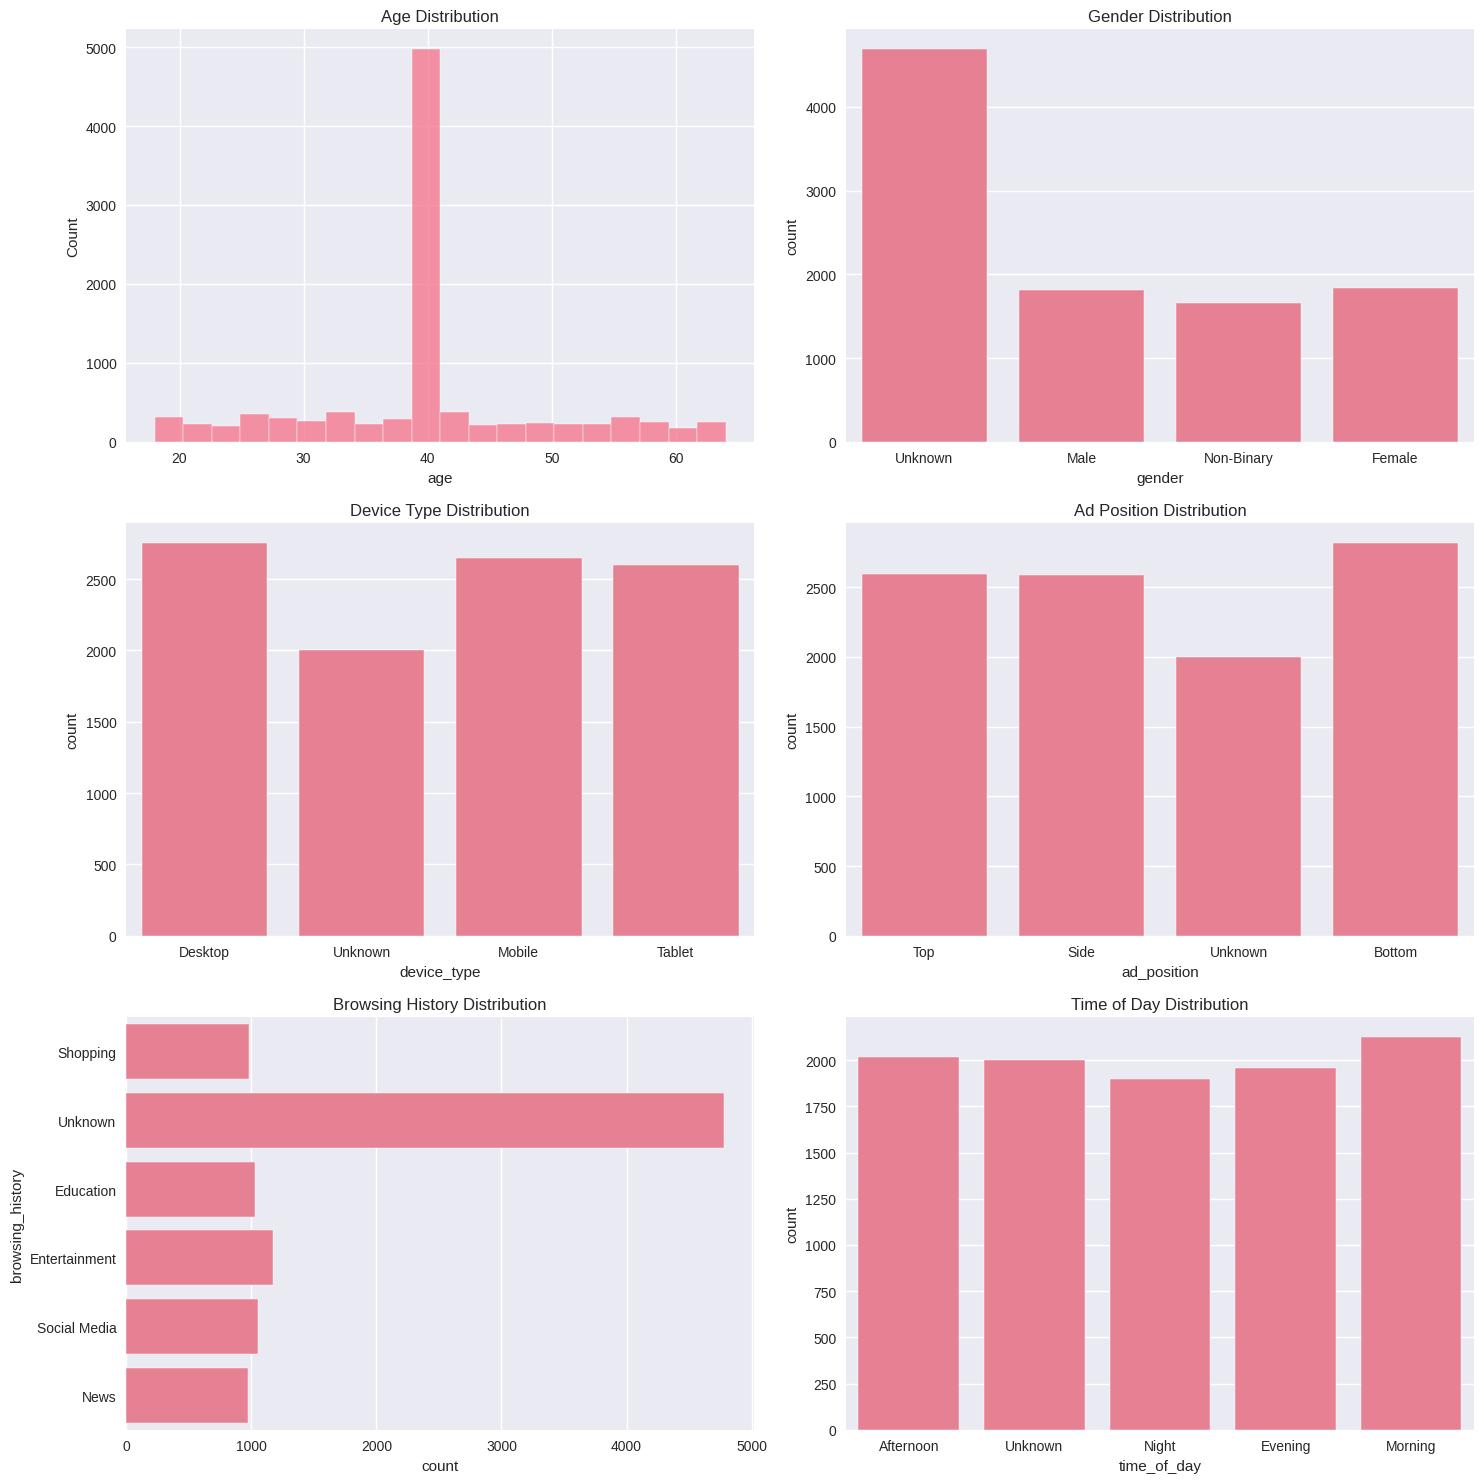

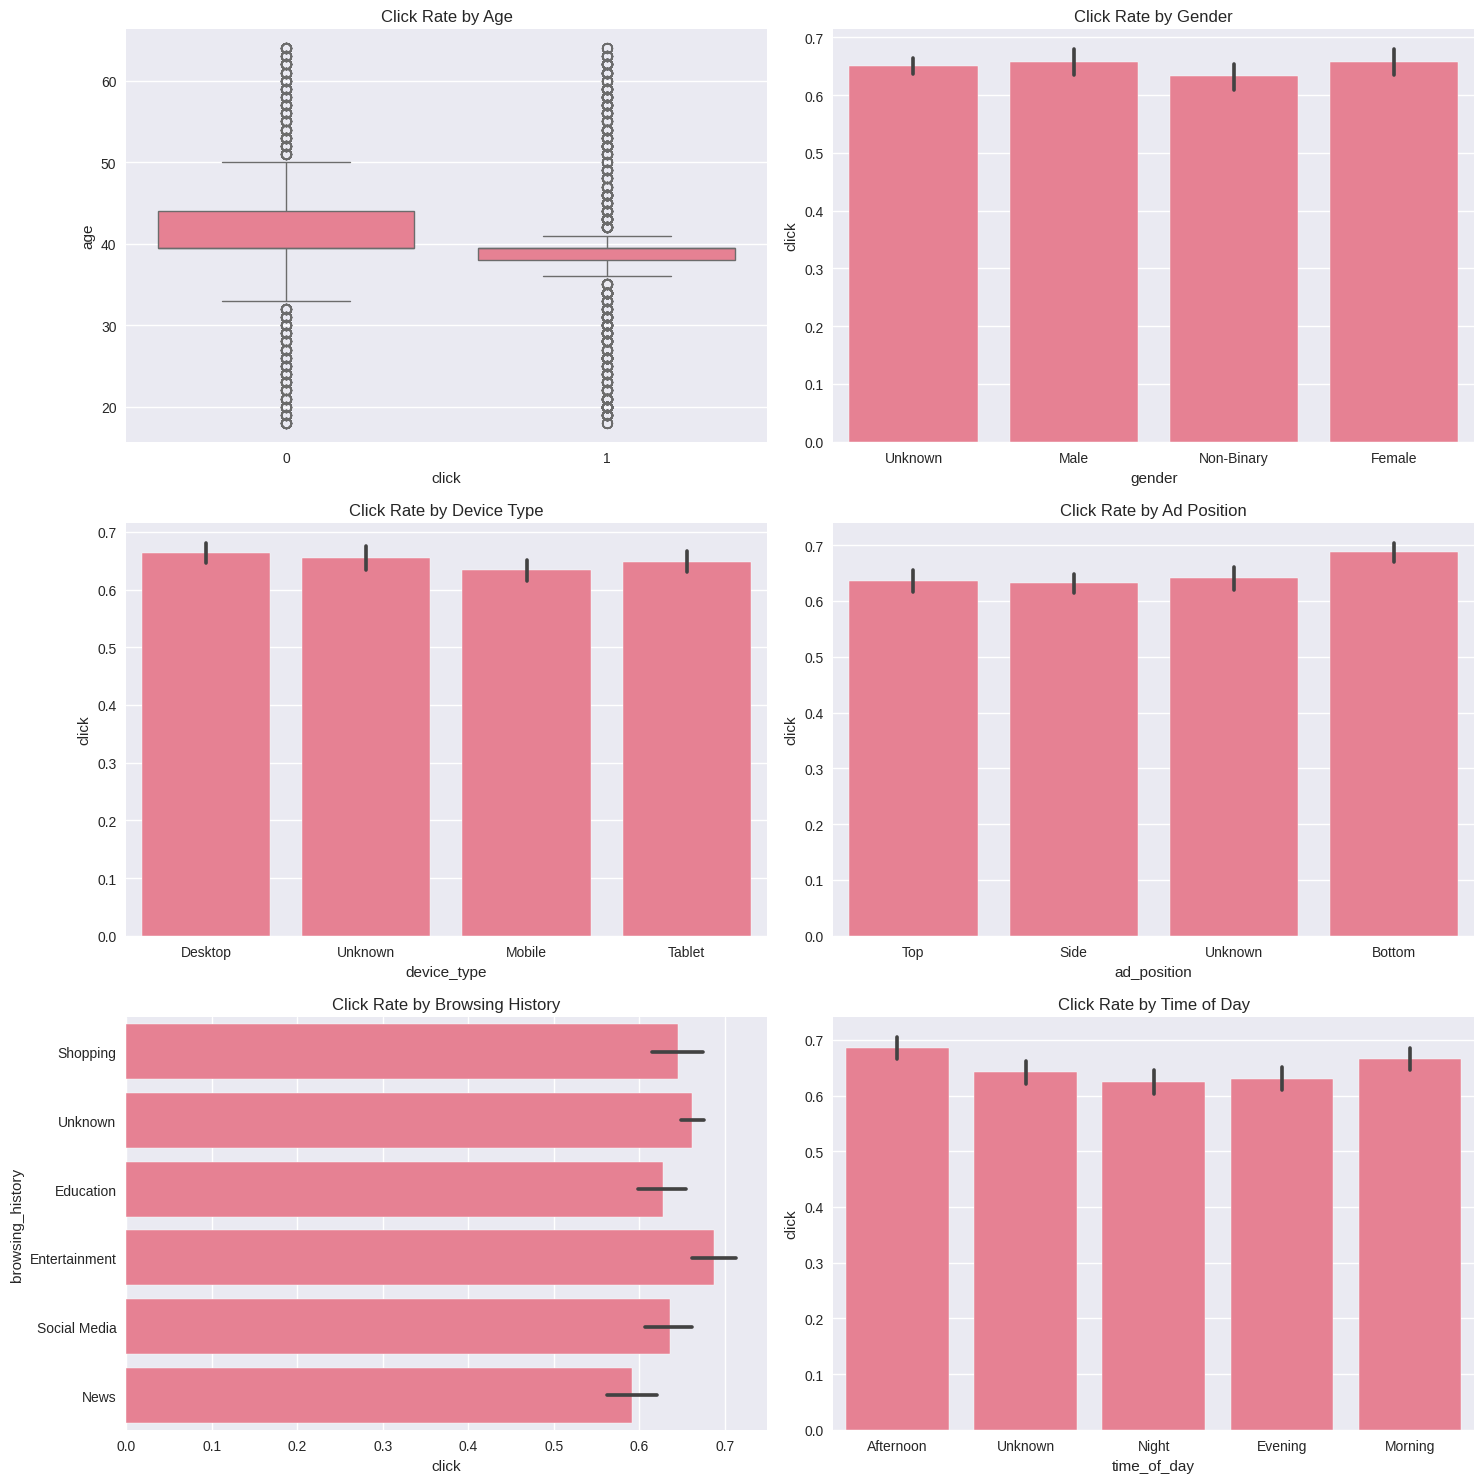

In [7]:
# Set up visualization style
plt.style.use('seaborn-v0_8')


sns.set_palette("husl")

# Plot distributions
fig, axes = plt.subplots(3, 2, figsize=(15, 15))

# Age distribution
sns.histplot(df['age'], bins=20, ax=axes[0, 0])
axes[0, 0].set_title('Age Distribution')

# Gender distribution
sns.countplot(data=df, x='gender', ax=axes[0, 1])
axes[0, 1].set_title('Gender Distribution')

# Device type distribution
sns.countplot(data=df, x='device_type', ax=axes[1, 0])
axes[1, 0].set_title('Device Type Distribution')

# Ad position distribution
sns.countplot(data=df, x='ad_position', ax=axes[1, 1])
axes[1, 1].set_title('Ad Position Distribution')

# Browsing history distribution
sns.countplot(data=df, y='browsing_history', ax=axes[2, 0])
axes[2, 0].set_title('Browsing History Distribution')

# Time of day distribution
sns.countplot(data=df, x='time_of_day', ax=axes[2, 1])
axes[2, 1].set_title('Time of Day Distribution')

plt.tight_layout()
plt.show()

# Click rate by different features
fig, axes = plt.subplots(3, 2, figsize=(15, 15))

# Click rate by age
sns.boxplot(data=df, x='click', y='age', ax=axes[0, 0])
axes[0, 0].set_title('Click Rate by Age')

# Click rate by gender
sns.barplot(data=df, x='gender', y='click', ax=axes[0, 1])
axes[0, 1].set_title('Click Rate by Gender')

# Click rate by device type
sns.barplot(data=df, x='device_type', y='click', ax=axes[1, 0])
axes[1, 0].set_title('Click Rate by Device Type')

# Click rate by ad position
sns.barplot(data=df, x='ad_position', y='click', ax=axes[1, 1])
axes[1, 1].set_title('Click Rate by Ad Position')

# Click rate by browsing history
sns.barplot(data=df, y='browsing_history', x='click', ax=axes[2, 0])
axes[2, 0].set_title('Click Rate by Browsing History')

# Click rate by time of day
sns.barplot(data=df, x='time_of_day', y='click', ax=axes[2, 1])
axes[2, 1].set_title('Click Rate by Time of Day')

plt.tight_layout()
plt.show()


In [8]:
# Create age bins
df['age_group'] = pd.cut(df['age'], bins=[0, 25, 35, 45, 55, 65],
                         labels=['18-25', '26-35', '36-45', '46-55', '56-65'])

# Create interaction features
df['device_ad_position'] = df['device_type'] + '_' + df['ad_position']
df['history_time'] = df['browsing_history'] + '_' + df['time_of_day']

# Check new features
print("\nNew feature distributions:")
print(df[['age_group', 'device_ad_position', 'history_time']].nunique())


New feature distributions:
age_group              5
device_ad_position    16
history_time          30
dtype: int64


In [9]:
# Define features and target
X = df.drop('click', axis=1)
y = df['click']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Define preprocessing for numerical and categorical features
numeric_features = ['age']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_features = ['gender', 'device_type', 'ad_position', 'browsing_history',
                       'time_of_day', 'age_group', 'device_ad_position', 'history_time']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Feature selection
selector = SelectKBest(score_func=f_classif, k=20)

In [10]:
# Define models to evaluate
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': xgb.XGBClassifier(random_state=42, eval_metric='logloss'),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000)
}

# Evaluate each model
results = {}
for name, model in models.items():
    # Create pipeline
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('selector', selector),
        ('classifier', model)])

    # Fit the model
    pipeline.fit(X_train, y_train)

    # Make predictions
    y_pred = pipeline.predict(X_test)
    y_prob = pipeline.predict_proba(X_test)[:, 1]

    # Store results
    results[name] = {
        'classification_report': classification_report(y_test, y_pred),
        'confusion_matrix': confusion_matrix(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_prob)
    }

    # Print results
    print(f"\n{name} Results:")
    print("Classification Report:")
    print(results[name]['classification_report'])
    print(f"ROC AUC Score: {results[name]['roc_auc']:.4f}")
    print("Confusion Matrix:")
    print(results[name]['confusion_matrix'])


Random Forest Results:
Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.32      0.43      1050
           1       0.71      0.91      0.80      1950

    accuracy                           0.70      3000
   macro avg       0.68      0.61      0.61      3000
weighted avg       0.69      0.70      0.67      3000

ROC AUC Score: 0.6989
Confusion Matrix:
[[ 335  715]
 [ 180 1770]]

XGBoost Results:
Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.29      0.40      1050
           1       0.71      0.93      0.80      1950

    accuracy                           0.71      3000
   macro avg       0.70      0.61      0.60      3000
weighted avg       0.70      0.71      0.66      3000

ROC AUC Score: 0.6875
Confusion Matrix:
[[ 300  750]
 [ 134 1816]]

Logistic Regression Results:
Classification Report:
              precision    recall  f1-score   support

           0    

In [11]:
# Based on initial results, let's tune XGBoost
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('selector', selector),
    ('classifier', xgb.XGBClassifier(random_state=42, eval_metric='logloss'))
])

# Define parameter grid
param_grid = {
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [3, 5, 7],
    'classifier__subsample': [0.8, 0.9, 1.0],
    'classifier__colsample_bytree': [0.8, 0.9, 1.0]
}

# Perform grid search
grid_search = GridSearchCV(xgb_pipeline, param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Best model
best_model = grid_search.best_estimator_
print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best ROC AUC score: {grid_search.best_score_:.4f}")

# Evaluate on test set
y_pred_best = best_model.predict(X_test)
y_prob_best = best_model.predict_proba(X_test)[:, 1]

print("\nBest Model Test Results:")
print("Classification Report:")
print(classification_report(y_test, y_pred_best))
print(f"ROC AUC Score: {roc_auc_score(y_test, y_prob_best):.4f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_best))

Fitting 5 folds for each of 243 candidates, totalling 1215 fits

Best parameters: {'classifier__colsample_bytree': 0.8, 'classifier__learning_rate': 0.2, 'classifier__max_depth': 7, 'classifier__n_estimators': 300, 'classifier__subsample': 0.9}
Best ROC AUC score: 0.7100

Best Model Test Results:
Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.34      0.45      1050
           1       0.72      0.91      0.81      1950

    accuracy                           0.71      3000
   macro avg       0.70      0.63      0.63      3000
weighted avg       0.71      0.71      0.68      3000

ROC AUC Score: 0.7004
Confusion Matrix:
[[ 356  694]
 [ 167 1783]]


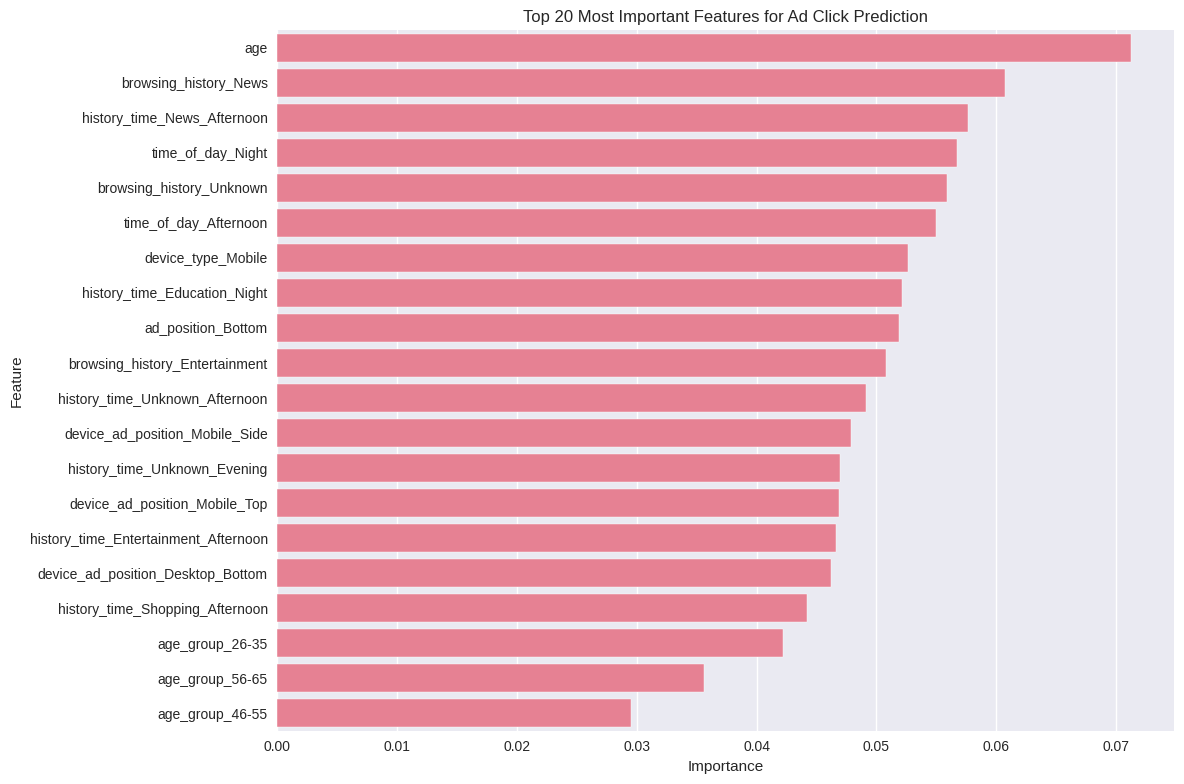

In [12]:
# Get feature names after preprocessing
preprocessor.fit(X_train)
numeric_feature_names = numeric_features
categorical_feature_names = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)
all_feature_names = np.concatenate([numeric_feature_names, categorical_feature_names])

# Get selected feature names
selector.fit(preprocessor.transform(X_train), y_train)
selected_indices = selector.get_support(indices=True)
selected_feature_names = all_feature_names[selected_indices]

# Get feature importances from the best model
importances = best_model.named_steps['classifier'].feature_importances_

# Create a DataFrame for visualization
feature_importance_df = pd.DataFrame({
    'Feature': selected_feature_names,
    'Importance': importances
}).sort_values('Importance', ascending=False)

# Plot top 20 features
plt.figure(figsize=(12, 8))
sns.barplot(data=feature_importance_df.head(20), x='Importance', y='Feature')
plt.title('Top 20 Most Important Features for Ad Click Prediction')
plt.tight_layout()
plt.show()

In [14]:
# Create a function to predict ad performance for new users
def predict_ad_performance(user_data, model=best_model):
    """
    Predicts whether a user will click on an ad.

    Args:
        user_data: Dictionary containing user features
        model: Trained model to use for prediction (default is our best model)

    Returns:
        Dictionary containing prediction and probability
    """
    # Convert user data to DataFrame
    user_df = pd.DataFrame([user_data])

    # Perform the same feature engineering as during training
    user_df['age_group'] = pd.cut(user_df['age'], bins=[0, 25, 35, 45, 55, 65],
                                labels=['18-25', '26-35', '36-45', '46-55', '56-65'])
    user_df['device_ad_position'] = user_df['device_type'] + '_' + user_df['ad_position']
    user_df['history_time'] = user_df['browsing_history'] + '_' + user_df['time_of_day']

    # Make prediction
    prob = model.predict_proba(user_df)[0, 1]
    prediction = int(prob > 0.5)  # Using 0.5 as threshold

    return {
        'will_click': prediction,
        'probability': float(prob),
        'recommendation': 'Show this ad' if prediction else 'Consider alternative ad'
    }

# Modified recommendation function
def recommend_ad_placement(user_profile):
    """
    Recommends the best ad position for a given user profile.

    Args:
        user_profile: Dictionary containing known user features

    Returns:
        Dictionary with recommended position and expected CTR
    """
    # Test all possible positions
    positions = ['Top', 'Side', 'Bottom']
    results = []

    for pos in positions:
        test_case = user_profile.copy()
        test_case['ad_position'] = pos

        # Create DataFrame and perform feature engineering
        test_df = pd.DataFrame([test_case])
        test_df['age_group'] = pd.cut(test_df['age'], bins=[0, 25, 35, 45, 55, 65],
                                     labels=['18-25', '26-35', '36-45', '46-55', '56-65'])
        test_df['device_ad_position'] = test_df['device_type'] + '_' + test_df['ad_position']
        test_df['history_time'] = test_df['browsing_history'] + '_' + test_df['time_of_day']

        prob = best_model.predict_proba(test_df)[0, 1]
        results.append((pos, prob))

    # Find best position
    best_pos, best_prob = max(results, key=lambda x: x[1])

    return {
        'recommended_position': best_pos,
        'expected_ctr': best_prob,
        'all_options': dict(results)
    }

# Example usage
example_user = {
    'age': 30,
    'gender': 'Female',
    'device_type': 'Mobile',
    'ad_position': 'Top',
    'browsing_history': 'Shopping',
    'time_of_day': 'Evening'
}

prediction = predict_ad_performance(example_user)
print("\nExample Prediction:")
print(prediction)

# Example usage for recommendation
example_profile = {
    'age': 28,
    'gender': 'Male',
    'device_type': 'Desktop',
    'browsing_history': 'News',
    'time_of_day': 'Afternoon'
}

recommendation = recommend_ad_placement(example_profile)
print("\nAd Placement Recommendation:")
print(recommendation)


Example Prediction:
{'will_click': 1, 'probability': 0.7829575538635254, 'recommendation': 'Show this ad'}

Ad Placement Recommendation:
{'recommended_position': 'Top', 'expected_ctr': np.float32(0.39413226), 'all_options': {'Top': np.float32(0.39413226), 'Side': np.float32(0.39413226), 'Bottom': np.float32(0.14797787)}}
